# HOMEWORK 3

## Open the homework in nbviewer to see the plots properly. Link below.
http://nbviewer.jupyter.org/github/hbjornoy/DataAnalysis/blob/master/Homework03/Homework%203.ipynb?flush_cache=true

Import all libraries needed in the Homework

In [1]:
import pandas as pd 
from IPython.display import display, HTML
import os
import numpy as np
import json
import folium
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, Image
%matplotlib inline

# Question 1


**********
Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.
**********

### IMPORT DATA AND CREATE A DATAFRAME

We downloaded the set : 
Unemployment rates by sex, age and nationality (%) which is a excel file(.xls)

In [2]:
# Import the excel file and call it xls_file
xls_file = pd.ExcelFile('Data/lfsa_urgan.xls')
initial_df = xls_file.parse()

#display the dataframe created above
display(initial_df.head())

,"Unemployment rates by sex, age and nationality (%) [lfsa_urgan]",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Last update,2017-09-19 12:42:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Extracted on,2017-11-01 14:04:51.393000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Source of data,Eurostat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that there are a lots of NaN because the dataframe represents exactly the cells of the excel files. And inside the file lots of cells are empty. We also observe in the file that there are 3 tables. One for the total of the population, One only for the Males and the last only for females. 
Therefore now we have to extract the table with the unemployement rate of the total population for 2016 for All the european countries.

To do so we :  
    - Extract the lines 17 to 50 which represents the unemployemend rate for the Total of the population for every country  
    - keep only  the most recents data which are in the last columns of the dataframe (i.e : 2016)

In [3]:
#Rename the useful columns
df = initial_df.copy()
df.rename(columns={'Unemployment rates by sex, age and nationality (%) [lfsa_urgan]':'Country'}, inplace=True)
df.rename(columns={'Unnamed: 10':'2016 Unemployement Rate'}, inplace=True)
#Keep the useful culumns
df = df[['Country','2016 Unemployement Rate']]
#Keep the lines representing individual countries between the 17th and the 49th
df_european_unemployement = df[df.Country=='European Union (28 countries)']
df_final = df[17:50].copy()
# Clean the name of the countries
df_final.Country.replace('Germany (until 1990 former territory of the FRG)','Germany',inplace=True)
df_final.Country.replace('Former Yugoslav Republic of Macedonia, the','The former Yugoslav Republic of Macedonia',inplace=True)

#display the head of the dataframe
display(df_final.head())

,Country,2016 Unemployement Rate
17,Belgium,7.9
18,Bulgaria,7.7
19,Czech Republic,4.0
20,Denmark,6.3
21,Germany,4.2


### Matching countries in the topojson and unemployment data.  
To make it possible to visualize the countries that we do not have data on. We will create a cleaned toposjon that only contain the matched countries.  
 - First we display all the countries inside the europe topojson  
 - Secondly we print the countries that are in our dataframe with the unemployement datas

In [4]:
#Open the topojson for europe
with open('topojson/europe.topojson.json') as f:    
    topo_json = json.load(f)
    #create an array 
    topo_countries = np.zeros(len(topo_json['objects']['europe']['geometries']), dtype=object)
    # Upload the array with the informations inside topojson
    for i, id_nr in enumerate(topo_json['objects']['europe']['geometries']):
        topo_countries[i] = id_nr['properties']['NAME']
    #sort the array topo_country
    topo_countries = sorted(topo_countries)
    
#print th countries in topojson europe      
print("Number of countries in 'topojson/europe.topojson.json':", len(topo_countries))
print(topo_countries)

#print the countries in the datas with unemployement rate
unemploy_countries = sorted(df_final['Country'])
print("\nNumber of countries in Unemployed rate data:", len(unemploy_countries))
print(unemploy_countries)

Number of countries in 'topojson/europe.topojson.json': 51
['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Holy See (Vatican City)', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'The former Yugoslav Republic of Macedonia', 'Turkey', 'Ukraine', 'United Kingdom']

Number of countries in Unemployed rate data: 33
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'M

Comment:  
We display all the countries which we do not have data on.  
Then, we compute a topojson without the irrelevant countries displayed

In [5]:
# Create a list where we will add all the country that are inside the dataFrame and inside the europetopojson
matching_countries = []
for topo_country in topo_countries:
    for unemploy_country in unemploy_countries:
        if unemploy_country == topo_country:
            matching_countries.append(topo_country)
            

#display all the countries that we will delete from the topojson and countries in our data not matching with the europetopojson            
no_match_topo_countries = np.setdiff1d(ar1=topo_countries, ar2=matching_countries)
no_match_unemploy_countries = np.setdiff1d(ar1=unemploy_countries, ar2=matching_countries)
print("Countries we are about to delete from our topojson:\n", no_match_topo_countries)
print("\nCountries not matched from Unemployed rate data:\n", len(no_match_unemploy_countries))

# load once again europe.topojson
with open('topojson/europe.topojson.json') as f:    
    eur_topojson = json.load(f)
    cleaned_eur_topojson = eur_topojson

# we keep only the relevant data in our cleand eur topojson
cleaned_eur_topojson['objects']['europe']["geometries"] = [x for x in cleaned_eur_topojson['objects']['europe']["geometries"] 
                                                           if x["properties"]["NAME"] not in no_match_topo_countries]

Countries we are about to delete from our topojson:
 ['Albania' 'Andorra' 'Armenia' 'Azerbaijan' 'Belarus'
 'Bosnia and Herzegovina' 'Faroe Islands' 'Georgia'
 'Holy See (Vatican City)' 'Israel' 'Liechtenstein' 'Monaco' 'Montenegro'
 'Republic of Moldova' 'Russia' 'San Marino' 'Serbia' 'Ukraine']

Countries not matched from Unemployed rate data:
 0


Now we have a dataframe with the county and their unemployement rate of 2016 and a topojson with ONLY the countries with datas. We will use this datas to build a Choropleth map which shows the unemployment rate in Europe at a country level. To do so we will implement a few things :   
- First we load the topojson of the europe.  
- Then we use the method shown in the tutorial to initialize the map of europe.  
- Finally we create a choropleth map to match the country with color depending on the unemployement rate   
- We display the borders of every countries in europe  
        All the countries with transparent layers are countries that we did not find unemployement rate. We deleted them from the topojson just above 

In [6]:
def quantile_thresholds(df, num_q):
    """
    This function takes in a df and number of desired quantiles. This is a way of making discrete categories of the
    data so that the probability of beeing in each category is approximately the same.
    It returns a list of the thresholds.
    These thresholds can be used to construct the categories in the choropleth map.
    """
    q_thresholds = []
    
    # Create different thresholds using the DataFrame.quantile() function
    for x in range(num_q):
        q_thresholds.append(df.quantile(x/(num_q)))
    q_thresholds.append(np.floor(max(df) + 1))
    q_thresholds = np.array(q_thresholds).astype('int')
    return list(q_thresholds)

In [7]:
#load json data on all of the european countries
country_geo_path = 'topojson/europe.topojson.json'
geo_json_data = open(country_geo_path)
#countries that we have unemployed data on
cleaned_topojson = cleaned_eur_topojson

#build a blank map of the europe
m_europe = folium.Map([48,8], tiles='cartodbpositron', zoom_start=2.6)

#create a layer of borders from all the countries in europe
folium.TopoJson(geo_json_data,
                'objects.europe',
                name='nodata_json',
                style_function=lambda feature: {
                    'fillColor': 'transparent',
                    'color' : 'black',
                    'weight' : 2,
                    'opacity' : 0.8
                    }
               ).add_to(m_europe)

#creating a layer of 'Quantile distribution of countries in categories'
m_europe.choropleth(geo_data=cleaned_topojson,
                    name='Linear thresholds',
                    data=df_final,
                    columns=['Country','2016 Unemployement Rate'],
                    key_on='feature.properties.NAME',topojson='objects.europe',
                    fill_color='BuPu', fill_opacity=0.9, line_opacity=0.2,
                    legend_name='Linear coloring: Percentage of unemployement rate (%)')

#creating a list of thresholds for the colorcoding of the quantile-choropleth
threshold_scale = quantile_thresholds(df_final['2016 Unemployement Rate'], 5)

#creating a layer of 'Quantile distribution of countries in categories'
m_europe.choropleth(geo_data=cleaned_topojson,
                    name='Quantile distribution of countries in categories',
                    data=df_final,
                    columns=['Country','2016 Unemployement Rate'],
                    key_on='feature.properties.NAME',topojson='objects.europe',
                    fill_color='BuPu', fill_opacity=0.9, line_opacity=0.2,
                    threshold_scale = threshold_scale,
                    legend_name='Quantile coloring: Percentage of unemployement rate (%)')


#create a symbol that make you able to turn ON and OFF the different layers
folium.LayerControl().add_to(m_europe)

#display the map
m_europe

### Instructions for the interactive map:
There is a white icon with "layers" in the upright corner of the map. Press this map to choose which layers to activate.
The colors do NOT represent the same interval of values it is only two different ways to visualize RELATIVE difference in unemployment between countries in Europe.
When analysing map <B>KEEP ONLY ONE LAYER</B> on at the same time!

There are 3 layers:
1. *"Borders of countries in europe"*
    - This layer is to show where the different countries in europe that we do not have data is located
2. *"Linear Threshold"*
    - This shows a coloring based on linear thresholds which makes it easier to represent absolute difference beetween countries since the categories are 3-4 precentages apart, so one can rougly calculate with visual information.
3. *"Quantile distribution of countries in categories"*
    - Quantile distrubution means that the different categories have the same amount of countries in it. This way the PS: it is rounded to nearest integer for better readability
    
#### Comment:
- The linear threshold has the ability to explain the absolute differences and how big the unemployment problem is in the nations with the highest unemployment. But if you are interested in the distribution or the subtle differences between the nations that have a lower unemployment, the linear threshold dont give you alot of information. The quantile distribution however give a more nuanced information about the most common unemployment numbers. The LEgend with thresholds can itself say alot about the distribution of unemploymentnumbers across nations.

***

## Compare Switzerland's unemployment rate to that of the rest of Europe.

In [8]:
# We create a dataframe call compare with the data for switzerland and the mean for the rest of the europe
frames = [df_final[df_final.Country == 'Switzerland'],df_european_unemployement.iloc[[0]]] 
result = pd.concat(frames)
display(result)

,Country,2016 Unemployement Rate
47,Switzerland,5.1
11,European Union (28 countries),8.7


We have the unemployement rate of 28 countries in Europe including Switzerland. We now try to display all the results in a histogram. We will use a bar plote.  

 - The Rate of Switzerland will be in GREEN  
 - The mean rate of european countries will be in RED

In [9]:
# Fonction to plot the histogram of unemployement rate
# Display the information in colors for datas displaied above
def plot_bars(column_name, number_bars, df, y_ticks_label, diff_colors):
    
    # create subplots and title
    fig, ax = plt.subplots()
    fig.suptitle('Swiss unemployment ratio compared to the rest of europe', fontsize=20)
    fig.set_size_inches(12, 10)
    
    # Define the variables
    N = 5
    ind = np.arange(number_bars)
    width = 0.5
    vals = df.head(number_bars)[column_name]
    
    # Setting colors of the regions/countries
    df = df.set_index(['Country'])
    # Using cm to construct colors of the length of diff_colors
    colors = cm.rainbow(np.linspace(0, 1, len(diff_colors)+1))
    colorlist = colorlist = [colors[0]] * df.shape[0]
    
    # Map the different regions to location in dataframe to get the right colors assosiated with the diff countries
    for c_ind, region in enumerate(diff_colors):
        colorlist[df.index.get_loc(region)] = colors[c_ind+1]
    
    # Plot the data
    ax.barh(ind, vals, width, color=colorlist, align='center')
    
    # Set labels and ticks
    ax.set_xlabel('Unemployment ratio in (%)', fontsize=20)
    ax.set_ylabel('Countries/Regions', fontsize=20)
    ax.set_yticks(np.arange(number_bars))
    ax.set_yticklabels(y_ticks_label, fontsize=12)
    
    # Values read top-to-bottom by default
    ax.invert_yaxis()
    # Show grid to easier evaluate data
    ax.xaxis.grid()

    plt.show()

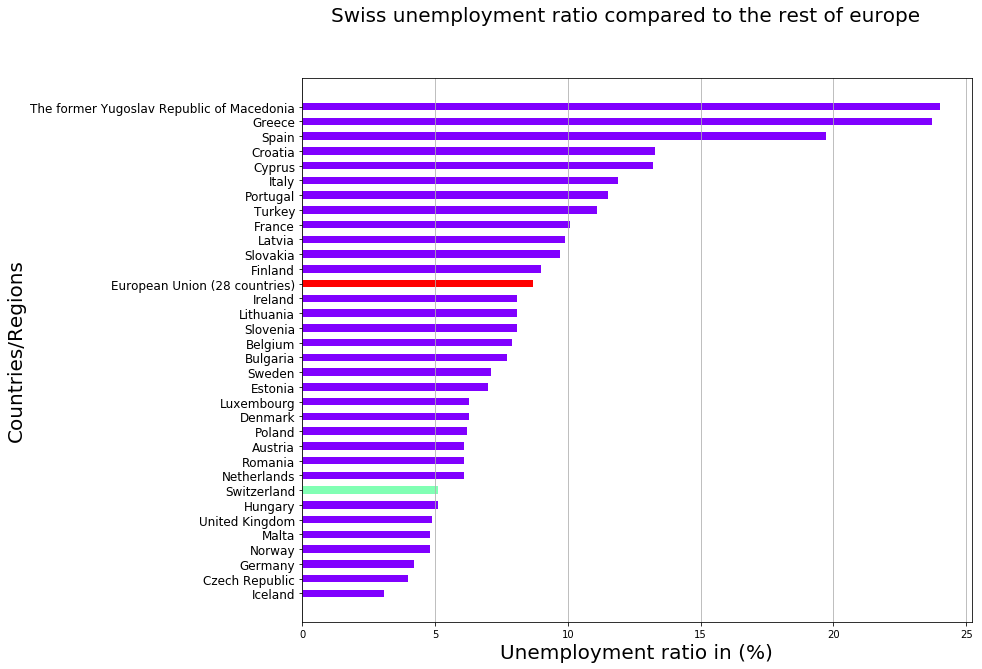

In [10]:
# Include the unemployment combined numbers for the EU nations
df_final = pd.concat([df_final,df_european_unemployement.iloc[[0]]])
df_final.drop_duplicates(inplace=True)

# Sort the dataframe after Uemployment rate so it is easier to do comparison between the countries
df_final = df_final.sort_values(by='2016 Unemployement Rate', ascending=False)

# Making the switzerland and EU stand out with colors in the histogram
countries_diff_color = ['Switzerland', 'European Union (28 countries)']

# Plot the histogram
plot_bars('2016 Unemployement Rate', len(df_final), df_final, df_final.Country, ['Switzerland', 'European Union (28 countries)'])

#### Comment: 
As shown by the bar plot above, we note that the unemployment rate of Switzerland in 2016 is generally lower than the unemployement rate of the european countries. One can also see the average Unemployment rate of the European Union. Again remember that there are over 20 other countries not included in these numbers. Mostly smaller sovereign principalities like Monaco and Andorra, some slavic countries in eastern europe and some jugoslavian countries.

PS: not all these countries are in the EU like Iceland and Norway that have very low Unemployment ratios.

# Question 2

**********
Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.
**********

### Import data and create a dataframe
We go to :  https://www.amstat.ch/v2/index.jsp and download the informations of unemployment rate at the level of swiss cantons and the statistics people who already have a job and are looking for a new one. We try to download the file in German to get the german names of the cantons to match the names in the topojson file.  
We get an excel file.  

The Cambridge Dictionary defines the active population to be "the people in a country or area who normally work and earn money".   
We considered the Unemployement Rate from amstat to be the Number of people without a job divided by the Active Population times 100. The homework definition of Unemployement Rate wasn't clear and did not seem relevant. We sticked to what we found on the amstat description. We Create and Analyze the Jobseeking rate to be the number of People searching for a job(currently with or without a job).

In [11]:
# Import the excel file and call it xls_file
xls_file = pd.ExcelFile('Data/amstat_DE.xlsx')
initial2_df = xls_file.parse()

#display the head of the dataframe
display(initial2_df.head())

,2.1 Arbeitslosenquoten,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kanton,Monat,September 2017,September 2017,September 2017,Gesamt,Gesamt,Gesamt
2,NaN,Metriken,Arbeitslosenquote,Registrierte Arbeitslose,Registrierte Stellensuchende,Arbeitslosenquote,Registrierte Arbeitslose,Registrierte Stellensuchende
3,Zürich,NaN,3.3,27225,34156,3.3,27225,34156
4,Bern,NaN,2.4,13658,18385,2.4,13658,18385


From the Dataframe above we now :  
- extract our relevant data  
- calculate the number of active population for each canton :  
        (NB Unemployed/Unemployement Rate) *100
- calculate the JobSeeker Rate which is the percentage of people seeking for a job:  
        (NB Job Seek/Active Population) * 100
- clean our data to get a nice cute dataframe  
- Add the ID for every Canton by hand because the display of the map with the ID will be easier than for the name   

In [12]:
#Rename the useful columns
df2 = initial2_df.copy()
df2.rename(columns={'Unnamed: 2':'Unemployement Rate','Unnamed: 3':'Nb Unemployed','Unnamed: 4':'Job Seeker'}, inplace=True)
df2.rename(columns={'2.1 Arbeitslosenquoten':'Canton'},inplace=True)
#Keep the useful culumns
df2 = df2[['Canton','Unemployement Rate','Nb Unemployed','Job Seeker']]

#keep the Unemployement rate in a dataframe
df_swiss_unemployement = df2[df2.Canton=='Total']

# Find the number of the active population for avery row 
df2_final = df2[3:29].copy()
df2_final['Active Population'] = round(pd.to_numeric(df2_final['Nb Unemployed']).div(pd.to_numeric(df2_final['Unemployement Rate']))*100)
#then we calculate the number of people looking for a job divided by the size of the active population (scaled by 100).
# We call it JobSeeker Rate
df2_final['JobSeeker Rate'] = round(pd.to_numeric(df2_final['Job Seeker']).div(pd.to_numeric(df2_final['Active Population']))*100,1)
# convert unemployement rate as float
df2_final['Unemployement Rate']=df2_final['Unemployement Rate'].astype(float)

#Create RostiData to use it in the BONUS 
RostiData = df2_final.copy()

df2_final = df2_final[['Canton','Unemployement Rate','JobSeeker Rate']]
#We create a column with the ID of every cantons to use it in the graph
df2_final['ID']=['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']
df2_final = df2_final.reset_index(drop=True)

display(df2_final.head())

,Canton,Unemployement Rate,JobSeeker Rate,ID
0,Zürich,3.3,4.1,ZH
1,Bern,2.4,3.2,BE
2,Luzern,1.7,3.0,LU
3,Uri,0.6,1.4,UR
4,Schwyz,1.7,2.6,SZ


### Import data and create another dataframe with age classes   
Now that we have our data we search for the data with AGE CLASSES. To do so we download another excel file from amstat with the age class. We will get three :  
  - 15-24
  - 25-49
  - 50+

We Do the same work on this datas that above for the whole population. We will fin the Job seeker Rate and Unemployement Rate for every canton and every Age Class(see the explanation for the part above)

In [13]:
# Import the excel file and call it xls_file
xls_file = pd.ExcelFile('Data/amstat_infos.xlsx')
initial_age_df = xls_file.parse()

#Rename the useful columns
swiss_age = initial_age_df.copy()
swiss_age.rename(columns={'Unnamed: 2':'Age Class','Unnamed: 4':'Unemployement Rate','Unnamed: 5':'Nb Unemployed','Unnamed: 6':'Job Seeker'}, inplace=True)
swiss_age.rename(columns={'2.1 Taux de chômage':'Canton'},inplace=True)
#Keep the useful culumns
swiss_age = swiss_age[['Canton','Age Class','Unemployement Rate','Nb Unemployed','Job Seeker']]

#keep the Unemployement rate in a dataframe
df_swiss_unemployement_age = swiss_age[swiss_age.Canton=='Total']

# Find the number of the active population for avery row 
swiss_age = swiss_age[3:81].copy()
swiss_age['Active Population'] = round(pd.to_numeric(swiss_age['Nb Unemployed']).div(pd.to_numeric(swiss_age['Unemployement Rate']))*100)
#then we calculate the number of people looking for a job divided by the size of the active population (scaled by 100).
# We call it JobSeeker Rate
swiss_age['JobSeeker Rate'] = round(pd.to_numeric(swiss_age['Job Seeker']).div(pd.to_numeric(swiss_age['Active Population']))*100,1)
swiss_age['Unemployement Rate']=swiss_age['Unemployement Rate'].astype(float)

#Keep the relevant Datas
swiss_age = swiss_age[['Canton','Age Class','Unemployement Rate','JobSeeker Rate']]
swiss_age = swiss_age.reset_index(drop=True)
display(swiss_age.head())

,Canton,Age Class,Unemployement Rate,JobSeeker Rate
0,Zurich,15-24 ans,3.7,4.2
1,Zurich,25-49 ans,3.4,4.2
2,Zurich,50 ans et plus,2.9,3.9
3,Berne,15-24 ans,2.8,3.4
4,Berne,25-49 ans,2.5,3.4


We change the dataframe to have all the datas from one Canton on ONE row

In [14]:
#Copy the datafram swiss_age into a new one to be able to launch this cell again and again.
Swiss_age = swiss_age.copy()
#Iterate over the dataframe
for i in Swiss_age.index : 
    if (Swiss_age.loc[i, 'Age Class'] == '15-24 ans') :
        #update the line
        Swiss_age.loc[i,'15-24_Unemp'] = Swiss_age.loc[i,'Unemployement Rate']
        Swiss_age.loc[i,'15-24_JobSeek'] = Swiss_age.loc[i,'JobSeeker Rate']
    elif (swiss_age.loc[i,'Age Class'] == '25-49 ans'):
        #Because we want all the data on the same line, we need to put it at i-1 
        Swiss_age.loc[i-1,'25-49_Unemp'] = Swiss_age.loc[i,'Unemployement Rate']
        Swiss_age.loc[i-1,'25-49_JobSeek'] = Swiss_age.loc[i,'JobSeeker Rate']
    else :
        #Same case here, we want our data on the first line of the cantons, hence the i-2
        Swiss_age.loc[i-2,'50+_Unemp'] = Swiss_age.loc[i,'Unemployement Rate'] 
        Swiss_age.loc[i-2,'50+_JobSeek'] = Swiss_age.loc[i,'JobSeeker Rate']
#We only want to keep every first row for each canton, so we take out the rest 
Swiss_age = Swiss_age.take(list(list(range(76))[::3]))

#Getting rid of the rows we do not want. 
Swiss_age = Swiss_age.drop(['Age Class', 'Unemployement Rate', 'JobSeeker Rate'], axis=1)

#Because some items were deleting, we must reset the index
Swiss_age = Swiss_age.reset_index(drop=True)

#Get the ID for every Canton
Swiss_age['ID']=['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']

display(Swiss_age.head())

,Canton,15-24_Unemp,15-24_JobSeek,25-49_Unemp,25-49_JobSeek,50+_Unemp,50+_JobSeek,ID
0,Zurich,3.7,4.2,3.4,4.2,2.9,3.9,ZH
1,Berne,2.8,3.4,2.5,3.4,2.2,3.1,BE
2,Lucerne,2.1,2.8,1.7,3.0,1.6,3.2,LU
3,Uri,0.5,0.8,0.5,1.2,0.7,1.7,UR
4,Schwyz,1.6,2.0,1.6,2.5,1.9,3.1,SZ


### DISPLAY THE RESULTS
First we display the map of Switzerland canton with the Job Seeker Rate. We use a similar technic than for the exercice one but this time we try to go further. To do so we use a fonction from folium call LayerControl()  
We display different layers on the map.  


In [15]:
def create_linear_thresholds(list_of_columns):
    """
    create a common linear threshold between the lowest registered value and the highest value across datasets.
    Return a list of threshold with linear spacing
    """
    # initialize the min and max
    temp_min = min(df2_final[list_of_columns[0]])
    temp_max = max(df2_final[list_of_columns[0]])

    for column in list_of_columns[1:]:
        if min(Swiss_age[column]) < temp_min : temp_min = min(Swiss_age[column])
        if max(Swiss_age[column]) > temp_max : temp_max = max(Swiss_age[column])
            
    thresholds = list(np.linspace(temp_min-0.001, temp_max+0.001, num=6, endpoint=True))
    print(thresholds)
    return thresholds

def create_choropleth(s_map, name, data, second_column):
    """
    This function create a choropleth map
    """
    #load the topojson of the switzerland cantons
    swiss_geo_path = 'topojson/ch-cantons.topojson.json'
    swiss_json_data = open(swiss_geo_path)
    
    #create the chorpleth layer for the map
    s_map.choropleth(geo_data=swiss_json_data,
                    data=data,name=name,
                    columns=['ID',second_column],
                    key_on='feature.id',topojson='objects.cantons',
                    fill_color='BuPu', fill_opacity=0.8, line_opacity=0.2,
                    legend_name= name+' in (%)',
                    threshold_scale=threshold_list)
    
    return s_map

# Create common linear threshold for the jobseeker datasets
# The minimal value will be in df2_final("Unemployment Rate") while the highest will be in the Swiss_age(15-24_JobSeek)
threshold_list = create_linear_thresholds(['Unemployement Rate','15-24_JobSeek','25-49_JobSeek','50+_JobSeek',
                                           '15-24_Unemp','25-49_Unemp'])

[0.499, 1.9194, 3.3398000000000003, 4.7602000000000002, 6.1806000000000001, 7.601]


In [16]:
#build a blank map of the europe
m_swiss = folium.Map([46.7,8], tiles='cartodbpositron', zoom_start=7.5)

#create different layers of cloropleth for the map m_swiss
m_swiss = create_choropleth(m_swiss, 'TOTAL Job Seeker Rate', df2_final, 'JobSeeker Rate')
m_swiss = create_choropleth(m_swiss, 'Age:15-24 Job Seeker Rate', Swiss_age, '15-24_JobSeek')
m_swiss = create_choropleth(m_swiss, 'Age:25-49 Job Seeker Rate', Swiss_age, '25-49_JobSeek')
m_swiss = create_choropleth(m_swiss, 'Age:50+ Job Seeker Rate', Swiss_age, '50+_JobSeek')

#create a symbol that make you able to turn ON and OFF the different layers
folium.LayerControl().add_to(m_swiss)

#display the map with the different layers
m_swiss

##### INSTRUCTIONS TO USE THE MAP : 
##### On the top right corner you see a little box. Put your mouse on it to manipulate the different Layers
##### Choose your age class or the Total. But select only on of the four layer otherwise the Colors will be compromise

We now display the map of unemployement Rate

In [17]:
#build a blank map of the europe
m_swiss2 = folium.Map([46.7,8], tiles='cartodbpositron', zoom_start=7.5)

#create different layers of cloropleth for the map m_swiss
m_swiss2 = create_choropleth(m_swiss2, 'TOTAL Unemployement Rate', df2_final, 'Unemployement Rate')
m_swiss2 = create_choropleth(m_swiss2, 'Age:15-24 Unemployement Rate', Swiss_age, '15-24_Unemp')
m_swiss2 = create_choropleth(m_swiss2, 'Age:25-49 Unemployement Rate', Swiss_age, '25-49_Unemp')
m_swiss2 = create_choropleth(m_swiss2, 'Age:50+ Unemployement Rate', Swiss_age, '50+_Unemp')

#create a symbol that make you able to turn ON and OFF the different layers
folium.LayerControl().add_to(m_swiss2)

#display the map with the different layers
m_swiss2


#### Explaining our choices in visualization:
- Why we used the same linear thresholds for jobseeker and unemployment
    - By using the same threshold it is easier to compare intuitively compare the numbers between the jobseeker map and the unemployment map. If they had different threshold the colours would be connected to another scale. The disadvantage is that one potentially don't use the whole scale. We chose to use linear thresholds since it would be nonsensical to use thresholds based on quantiles. Since we are working on different distributions of number it wouldn't make any sense unless we did separate from each one
- Why we choose to use layers to visualize the difference different ages
    - We chose to use layers to because it is easier to see differences when switching the layer and the image is still. Much better for comparing the same canton and the individual changes.
- We wanted float threshold instead of integers
    - The folium library has its limitations. If you don't define a threshold_scale in choropleth then you get nice thresholds with decimals. But if you define your threshold that is not an opportunity. We would love for it to be linear. Now that it is not linear the spacing between the threshold is in the range of 1 to 2, which is a big difference. This makes the viewer very dependant on checking the thresholds on the legend to really understand the colouring.
- why we choose "BuPu" colour gradient
    - We started with having an 'OrRd' colour gradient. We thought the red would be a good indicator of negative effect. But we had trouble differentiating very strong red colours and therefore used "BuPu" which is much better for differentiating similar colours. 

#### Comments on data:
- One can clearly see that it is a trend that the western part of Switzerland both has higher unemployment and jobseeking rates. Even though a map is not the best visualization tool to make conclusion about correlation, there is clearly a correlation between unemployment and jobseekers
- COMMENT THE TRENDS

# QUESTION 3

**********  
Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.
**********

### Differences between Foreign Unemployment rate and Swiss Unemployement rate for each Canton

Once again we go to the amstat website. This time we download the unemployement rate by canton for foreign and swiss workers.  
We then create a dataframe with :  
 - Foreign Unemployement Rate  
 - Swiss Unemployement Rate  
 - The difference bewtween both rates :
         diff = ForeignRate-SwissRate  
 - The ID for each canton

In [18]:
# Import the excel file and call it xls_file
xls_file = pd.ExcelFile('Data/amstat_foreign.xlsx')
initial_foreign_df = xls_file.parse()

#Rename the useful columns
swiss_foreign = initial_foreign_df.copy()
swiss_foreign.rename(columns={'Unnamed: 1':'Nationality','Unnamed: 3':'Unemployement Rate'}, inplace=True)
swiss_foreign.rename(columns={'2.1 Taux de chômage':'Canton'},inplace=True)
#Keep the useful culumns
swiss_foreign = swiss_foreign[['Canton','Nationality','Unemployement Rate']]
#Keep the usful rows
swiss_foreign = swiss_foreign[3:55]

# Create two new columns in the dataframe one for the Foregin Rate and the other for the Swiss Rate
for i in swiss_foreign.index:
    if (swiss_foreign.loc[i,'Nationality']=='Etrangers'):
        swiss_foreign.loc[i,'Foreign Rate'] = swiss_foreign.loc[i,'Unemployement Rate']
    elif (swiss_foreign.loc[i,'Nationality']=='Suisses'):
        swiss_foreign.loc[i-1,'Swiss Rate'] = swiss_foreign.loc[i,'Unemployement Rate']        
# now we drop one row over 2
swiss_foreign = swiss_foreign[swiss_foreign['Nationality']=='Etrangers']
#keep the relevant columns
swiss_foreign = swiss_foreign[['Canton','Foreign Rate','Swiss Rate']]

#reset the index
swiss_foreign = swiss_foreign.reset_index(drop = True)

#Add a colum with the difference between Foreign rate and swiss rate annd add of the Canton's ID
swiss_foreign['Diff']=pd.to_numeric(swiss_foreign['Foreign Rate'])-pd.to_numeric(swiss_foreign['Swiss Rate'])
swiss_foreign['ID']=['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']

display(swiss_foreign.head())

,Canton,Foreign Rate,Swiss Rate,Diff,ID
0,Zurich,5.3,2.5,2.8,ZH
1,Berne,5.5,1.8,3.7,BE
2,Lucerne,3.9,1.3,2.6,LU
3,Uri,2.1,0.4,1.7,UR
4,Schwyz,3.4,1.2,2.2,SZ


Display of the map with color corresponding to the differences between Foreign Unemployment rate and Swiss Unemployement rate for each Canton.  
    We change the colors of the map this time because we display a differencrial rate. It is not a Real unemployement rate.

In [19]:
#build a blank map of Switzerland
map_diff = folium.Map([46.7,8], tiles='cartodbpositron', zoom_start=7.5)

#load the topojson of the switzerland cantons
swiss_geo_path = 'topojson/ch-cantons.topojson.json'
swiss_json_data = open(swiss_geo_path)

#creation of the choropleth map
map_diff.choropleth(geo_data=swiss_json_data,
                    data=swiss_foreign,name='Difference between Foreign rate and swiss rate',
                    columns=['ID','Diff'],
                    key_on='feature.id',topojson='objects.cantons',
                    fill_color='BuGn',fill_opacity=0.7, line_opacity=0.2,
                    legend_name='Difference btw Foreign and swiss Uneployement Rate (%)')

map_diff

Since the map represents a difference it could have been negative numbers. In that case we would have displayed another color than green, to tend to the red. Shades of red for negative values could have helped to identify the diversity of the gap between foreign and national unemployment

###  Refine the analysis by adding the differences between age groups
We assumed that we are asked to to analyze the Unemployment Rate for the age classes regardless of the Nationality of the people. We searched thru amstat to get those informations depending on the nationality but we did not find anything.  
We use the datas from exercice two with all the age classes for every Canton. We already showed a map above of the unemployement rate for every Age Class.

In [20]:
# We display the dataframe with the unemployement rate for every age class
display(Swiss_age.head())

,Canton,15-24_Unemp,15-24_JobSeek,25-49_Unemp,25-49_JobSeek,50+_Unemp,50+_JobSeek,ID
0,Zurich,3.7,4.2,3.4,4.2,2.9,3.9,ZH
1,Berne,2.8,3.4,2.5,3.4,2.2,3.1,BE
2,Lucerne,2.1,2.8,1.7,3.0,1.6,3.2,LU
3,Uri,0.5,0.8,0.5,1.2,0.7,1.7,UR
4,Schwyz,1.6,2.0,1.6,2.5,1.9,3.1,SZ


Now that the DataFrame has handiest shape to be used, we draw the barplot. To do so we take the total unemployment from the second question and add it to Swiss_age in order to be able to sort cantons by unemployment. Doing this will allow us to have a better overview of unemployment with respect to ages. 

In order to have a clearer visual, we divide the Swiss_age into 3 dataframes and process them separately. This will allow us to have a clearer display.
To implement the barplot we specify some parameters at the begining and then use them throughout the project.

In [21]:
#We extract the total unemployment from the df2, from which we reset the index to avoid mismatches

df2_final = df2_final.reset_index(drop=True)
Swiss_age['Unemployment_tot'] = pd.to_numeric(df2_final['Unemployement Rate'])
Swiss_age = Swiss_age.sort_values('Unemployment_tot', ascending=False)

#We then need to reset the index in order to manipalte the data easily
Swiss_age = Swiss_age.reset_index(drop=True)

#The barplot would have been too big if we plotted it entirely, thus why
#we divided the DataFrame into 3 parts and then display the results.

Age1 = Swiss_age.loc[0:9]
Age2 = Swiss_age.loc[10:15]
Age3 = Swiss_age.loc[16:]

#Defining a function to plot the 3 results.
def Barploting(SubSwissAge):
    #Establishing parameters for position and width that we will use all along. 
    pos = list(range(len(SubSwissAge['Canton']))) 
    width = 0.25
        
    # Creating the plot
    fig, ax = plt.subplots(figsize=(20,10))    
    #Defining the parameters
    plt.bar(pos, 
            SubSwissAge['15-24_Unemp'], 
            width,
            #Choosing the color:
            color='#EE3224', 
            label=SubSwissAge['Canton']) 
    
    #The position has to be further in order not to overlap the first bar
    plt.bar([p + width for p in pos], 
            SubSwissAge['25-49_Unemp'], 
            width,
            # Choosing the color:
            color='#F78F1E', 
            label=SubSwissAge['Canton']) 
    
    #The position is 2*width further to avoid overlapping
    plt.bar([p + width*2 for p in pos], 
            SubSwissAge['50+_Unemp'], 
            width,
            # Choosing the color:
            color='#FFC222', 
            # with label the third value in first_name
            label=SubSwissAge['Canton'])
    
    #Setting the labels
    ax.set_xticklabels(SubSwissAge['Canton'])
    #Setting the sizes of the labels
    ax.set_xticks([p + 1.5 * width for p in pos])
    ax.set_title('Unemployment rate per Canton [%]')
    #We must set the scale of y, because we will show 3 graphs and to avoid misleading visualization, 
    #they should have the same scale
    ax.set_ylim(0,7)
    
    # Adding the legend 
    plt.legend(['Age: 15-24', 'Age: 25-49', 'Age: 50+'], loc='upper left')
    plt.show()
    return 

We plot the results

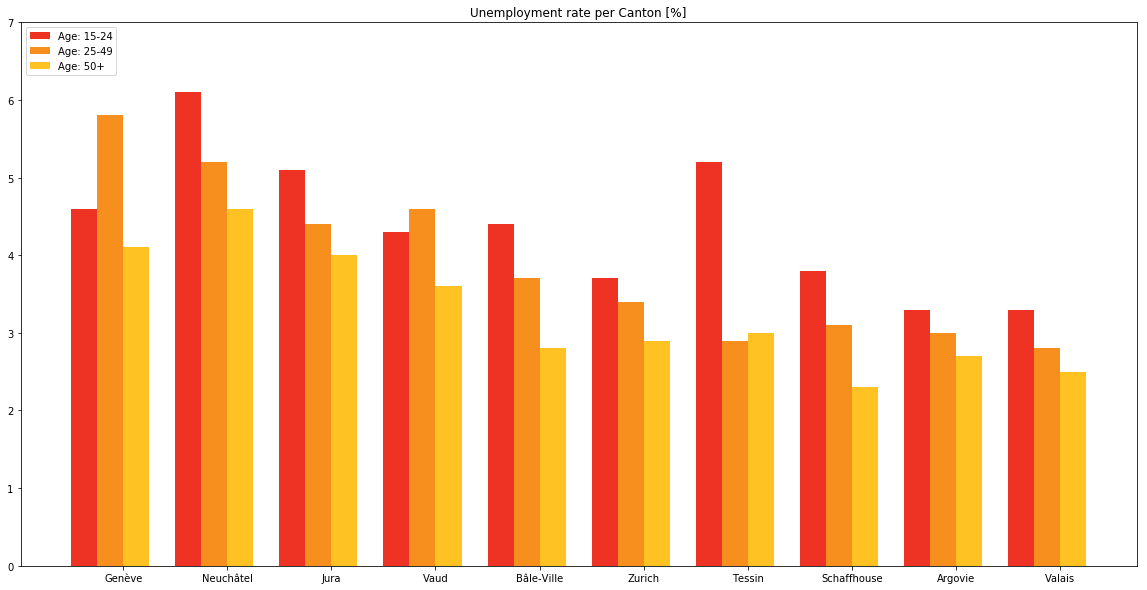

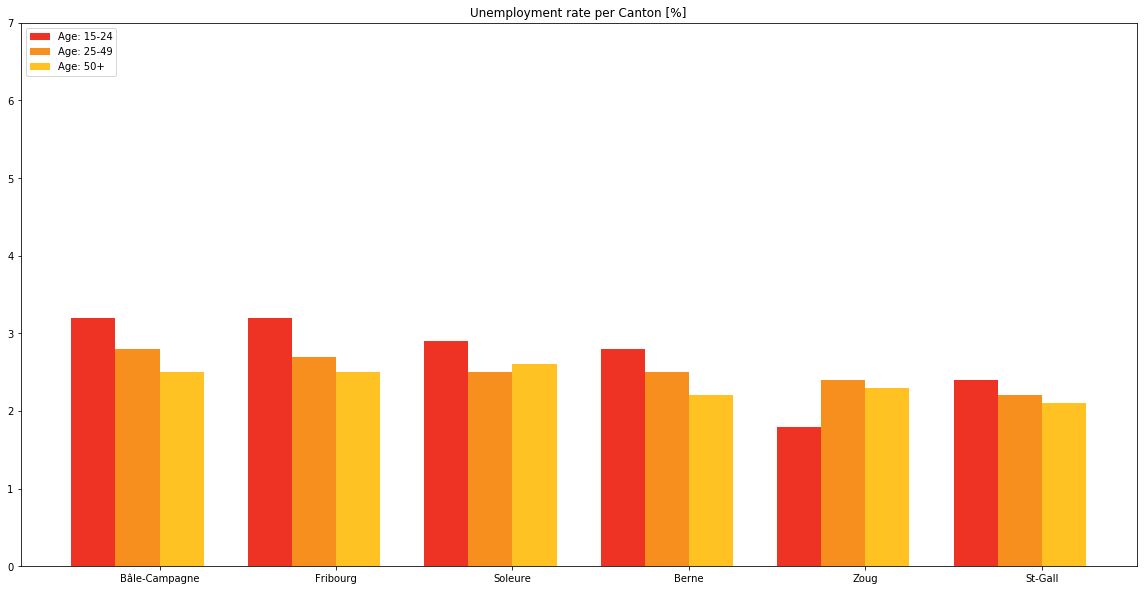

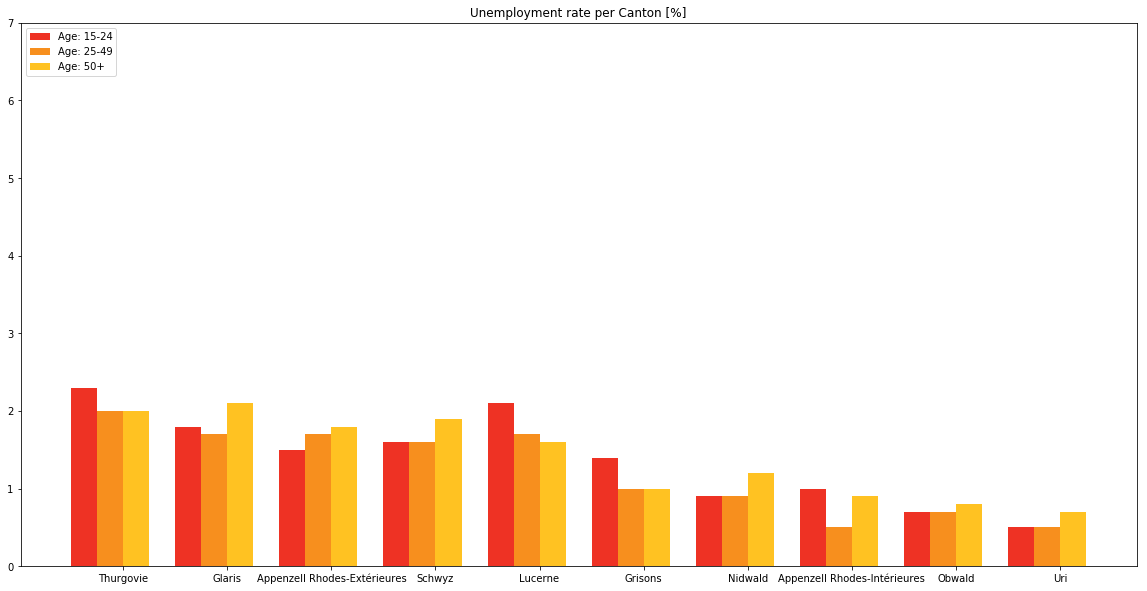

In [22]:
#Plotting the results
Barploting(Age1)
Barploting(Age2)
Barploting(Age3)

One can notice that there are not too many difference between age classes. Apart from Tessin, other cantons do not seem to show any significant differences in terms of unemployment rate. We can even prove it using Pearson's correlation:

In [23]:
#Defining a name vector to visualize the data
Names = ['15-24', '25-49', '50+']
#Defining correlations
Correlations = [Swiss_age['Unemployment_tot'].corr(Swiss_age['15-24_Unemp']),
                    Swiss_age['Unemployment_tot'].corr(Swiss_age['25-49_Unemp']),
                    Swiss_age['Unemployment_tot'].corr(Swiss_age['50+_Unemp'] )]
UnemploymentCorr = pd.DataFrame(columns=[Names, Correlations]) 

print('Correlations between general unemployment and age categories:')
display(UnemploymentCorr)

Correlations between general unemployment and age categories:


,15-24,25-49,50+
,0.941065,0.996370,0.982844


#### Conclusion
There is a strong correlation between the general unemployment in cantons and the value for the youngest part of the active population. However it is normal because the total is aggretated from the ages. Being the least correlated shows that in general on the Swiss labour market, youngters tend to more unemployed than the rest.

# 4. BONUS
Our strategy is to consider cantons that are crossed by the Röstigraben as fully belonging to one side, and then we deal with expection further in our work.
    1. Roughly aggregate the data for the Roman and German part
    2. Deal with exceptions
    3. Display results
    
To aggreagate the data from all the cantons, we use df2_final from question 2. We cloned the dataframe before removing all the raw data (total active population per canton, total unemployment per canton).

Once we have the aggregate, we treat exceptions. We assume at first that Valais and Freiburg are part of Roman Switzerland, while Berne is considered as entirely German-speaking. We did such division because those region provide only one distric that belongs to the other side, which makes the data processing much simpler.

In [24]:
#As it was extracted in the second excercise, we use the RostiData. 

#To extract the data per canton, we must reset the index to "Canton"
RostiData = RostiData.set_index('Canton')

#Putting all the Roman Cantons into a vector
RomanSwiss = ['Jura', 'Genf', 'Neuenburg', 'Wallis', 'Freiburg', 'Waadt' ]

#Getting the total active population and unemployed number, extract the number from RostiData
RomanUnemployed = 0
RomanActive = 0
for i in RomanSwiss : 
    RomanUnemployed += RostiData.loc[i, 'Nb Unemployed']
    RomanActive += RostiData.loc[i, 'Active Population']

print(RomanUnemployed)
print(RomanActive)

#We can then compute the values for the German-speaking part, getting of the Tessin because it is not German-speaking
GermanUnemployed = pd.to_numeric(RostiData['Nb Unemployed'].sum()) - RomanUnemployed - RostiData.loc['Tessin', 'Nb Unemployed']
print(GermanUnemployed)
GermanActive = RostiData['Active Population'].sum() - RomanActive  - RostiData.loc['Tessin', 'Active Population']
print(GermanActive)

45028
1101326.0
82939
3242717.0


Let's deal with the trickiest part, the cantons that are crossed by the Röstigraben. 

We have 3 cases to handle, because 3 cantons are crossed by the Röstigraben: Valais, Fribourg and Bern. 
One can notice that the subregions are not crossed by the Röstigraben, which is a property that we will take advantage of.

#### Fribourg
For Fribourg, the only German-speaking subregion is Singine. From the following document on the administration's website:

http://www.fr.ch/spe/files/pdf95/infobulle_09_2017.pdf

One can find that the number of unemployed is 335, and that the unemployement rate is 1.4 %

The active population is expressed by round(335/0.014) = 23929 persons.



In [25]:
#Defining variables:
Singine_total_actpop = 23929
Singine_total_unemployed = 335

#Substracting this to the Roman part
RomanActive = RomanActive - Singine_total_actpop
RomanUnemployed = RomanUnemployed - Singine_total_unemployed

#Adding it to the German part
GermanActive = GermanActive + Singine_total_actpop
GermanUnemployed = GermanUnemployed + Singine_total_unemployed

#### Valais
For Valais, only Haut-Valais belongs to the German-Speaking part. The following docuement provides us the data:

https://www.vs.ch/documents/529400/3288791/Bulletin+statistique+septembre+2017/69e39158-6268-41f4-8a89-d8617d649661


One can find that the number of unemployed is 368, and that the unemployement rate is 0.8 %

The active population is expressed by round(368/0.008) = 46000 persons.


In [26]:
HValais_total_actpop = 46000 
HValais_total_unemployed = 368

#Substracting this to the Roman part
RomanActive = RomanActive - HValais_total_actpop
RomanUnemployed = RomanUnemployed - HValais_total_unemployed

#Adding it to the German part
GermanActive = GermanActive + HValais_total_actpop
GermanUnemployed = GermanUnemployed + HValais_total_unemployed

#### Bern
For Bern, only "Berner Jura" belongs to the French speaking part
    One can find the data of this "Arrondissement" from the following website:
http://www.vol.be.ch/vol/fr/index/arbeit/arbeitslosigkeit.assetref/dam/documents/portal/Medienmitteilungen/de/2017/10/2017-10-10-vk-tabelle-september.pdf

One can find that the number of unemployed is 931, and that the unemployement rate is 3.4 %
The active population is expressed by round(931/0.034) = 27382. persons.

In [27]:
JuraBern_total_actpop = 27382
JuraBern_total_unemployed = 931

#Substracting the data to the German part
GermanActive = GermanActive - JuraBern_total_actpop
GermanUnemployed = GermanUnemployed - JuraBern_total_unemployed

#Adding it to the Roman part 
RomanActive = RomanActive + JuraBern_total_actpop
RomanUnemployed = RomanUnemployed + JuraBern_total_unemployed

In [28]:
#Computing the rates
RomanRate = (RomanUnemployed/RomanActive)*100
GermanRate = (GermanUnemployed/GermanActive)*100
print(RomanRate)
print(GermanRate)

4.27435753826
2.51763632999


#### Displaying the map of unemployement 
We could not find any useful and efficient way to use JSON files to display the unemployement along the Röstigraben. One option we had was to roughly draw a line and then apply our data to it. However it seemed to imprecise to us. We chose to find a real map of the Röstigraben on the internet and we added our results manually. The website is the following:  
             http://www.kleinreport.ch/news/rostigraben-soll-zum-kulturerbe-werden-79466/  
               
We are completely aware that this is by far not the best way to do it, especially after using those data visualization tools. However it remains the most accurate and the final visual is useful to understand the anwser to this question.

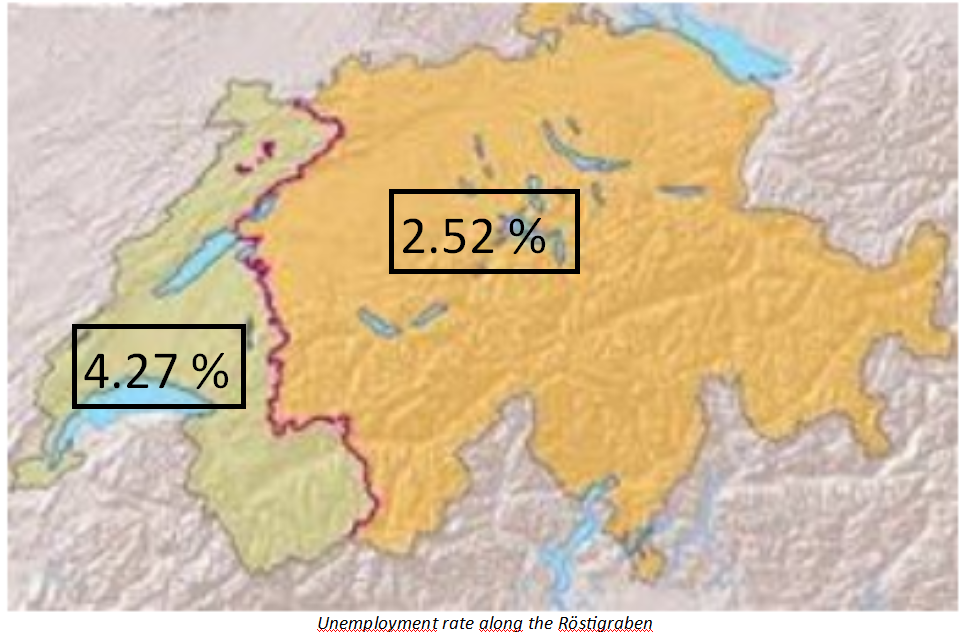

In [29]:
display(Image(filename='Rosti_Map.png'))
